<a href="https://colab.research.google.com/github/yurigalindo/FilteringMeteors/blob/master/Uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip /content/gdrive/My\ Drive/labeled_data.zip -d labeled_data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/labeled_data.zip
   creating: labeled_data/train/
   creating: labeled_data/train/NotMeteoros/
  inflating: labeled_data/train/NotMeteoros/M20170425_005651_UVP_1P.jpg  
  inflating: labeled_data/train/NotMeteoros/M20160126_235157_MCZ_3P.jpg  
  inflating: labeled_data/train/NotMeteoros/images (5) (another copy).jpg  
  inflating: labeled_data/train/NotMeteoros/M20170502_014445_OMC_1P.jpg  
  inflating: labeled_data/train/Not

In [0]:
#from __future__ import print_function, division 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from skimage import io, transform
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomOrder([
          transforms.Resize((420,420))
          #transforms.RandomHorizontalFlip(),
          #transforms.RandomRotation(45),
          #transforms.RandomVerticalFlip()
          ]
        ),
        #transforms.ColorJitter(0.5,0.5,0.5,0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((420,420)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((420,420)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'labeled_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid','test']}

In [0]:
import matplotlib.pyplot as plt
import torch

class Learner:
    #adapt code for emulating big batches
    def __init__(self,model,criterion):
        self.model=model
        self.criterion=criterion
        self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.best_acc=0

    def set_datasets(self,training,valid):
        self.training_dataset=training
        self.validation_dataset=valid
    def set_optimizer(self,optimizer,scheduler):
        self.optimizer=optimizer
        self.scheduler=scheduler
    def propagate_batch(self,inputs,labels):
        with torch.set_grad_enabled(True):
            outputs=self.model(inputs)
            size=inputs.size(0)
            del inputs
            loss = self.criterion(outputs, labels)
            #loss.requires_grad=True
            loss.backward()
            
        with torch.no_grad():
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item() 
            loss_item=loss.item()
        del preds
        del outputs
        del loss
        del labels
        return loss_item*size,corrects

    def eval_batch(self, inputs, labels):
        with torch.no_grad():
            outputs=self.model(inputs)
            loss = self.criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item()
            size=inputs.size(0)
            loss_item=loss.item()
        del outputs
        del loss
        del preds
        del inputs
        del labels
        return loss_item*size,corrects

    def print_statistics(self,loss,accuracy):
        print("  Avg Loss={}\n  Accuracy={}".format(loss,accuracy))
    def ceildiv(self,a, b):
        """Return the celing of the division of a by b
        """
        return -(-a // b)
    def min_value(self,a,b):
        """Return the smaller of two values
        """
        if a>b:
            return b
        else:
            return a
    def max_value(self,a,b):
        """"Return the greater of two values
        """
        if b>a:
          return b
        else:
          return a
    def change_to_best_model(self):
        self.model.load_state_dict(self.best_model_wts)
    def train(self,num_epochs,training_batchsize,validation_batchsize,batch_cap=32):
        """Train the learner's model for num_epochs on training batchsize, printing the train and validation loss and accuracy
        """
        batch_cap=self.min_value(training_batchsize,batch_cap)
        train_dataloader=torch.utils.data.DataLoader(self.training_dataset,batch_size=batch_cap,shuffle=True)
        
        training_batches=self.ceildiv(len(self.training_dataset),training_batchsize)
        micro_batches=training_batchsize//batch_cap #accuracy statistics will only work properly if training batch is divisible by batch_cap
        valid_dataloader=torch.utils.data.DataLoader(self.validation_dataset,batch_size=validation_batchsize,shuffle=True)
        validation_batches=self.ceildiv(len(self.validation_dataset),validation_batchsize)
        since = time.time()
        train_losses=[]
        valid_losses=[]
        for epoch in range(num_epochs):
            print("Epoch {} of {}".format(epoch,num_epochs-1))
            
            

            self.model.train()
            #Train model
            loss = 0
            corrects = 0
            iterator = iter(train_dataloader)
            #for batch in range(training_batches):
            for batch in range(training_batches):
                self.optimizer.zero_grad()
                try:
                  for micro_batch in range(micro_batches):

                    inputs,labels=next(iterator)
                    new_loss , new_corrects = self.propagate_batch(inputs.to(self.device),labels.to(self.device))
                    loss+=new_loss
                    corrects+=new_corrects
                    del inputs
                    del labels
                    del new_loss
                    del new_corrects
                    torch.cuda.empty_cache()
                except StopIteration:
                    pass
                self.optimizer.step()
                torch.cuda.empty_cache()

            self.scheduler.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()
            train_losses.append(loss/len(self.training_dataset))
            print("Training:")
            self.print_statistics(loss/len(self.training_dataset),corrects/len(self.training_dataset))
            
            
            #self.model.eval()
            #Evaluate model
            loss = 0
            corrects = 0
            iterator = iter(valid_dataloader)
            for batch in range(validation_batches):
                inputs,labels=next(iterator)
                new_loss , new_corrects=self.eval_batch(inputs.to(self.device),labels.to(self.device))
                loss+=new_loss
                corrects+=new_corrects
                del inputs
                del labels
                del new_loss
                del new_corrects
                torch.cuda.empty_cache()
            valid_losses.append(loss/len(self.validation_dataset))
            acc=corrects/len(self.validation_dataset)
            print("Validation:")
            self.print_statistics(loss/len(self.validation_dataset),acc)
            print()
            if(acc>self.best_acc):
              self.best_acc=acc
              self.best_model_wts = copy.deepcopy(self.model.state_dict())
            

        time_elapsed = time.time() - since
        print("Total time:{}".format(time_elapsed))
        plt.plot(range(num_epochs),train_losses,'r',range(num_epochs),valid_losses,'b')
        del train_dataloader
        del valid_dataloader
        del train_losses
        del valid_losses
        torch.cuda.empty_cache()
    def predict(self,dataset,batchsize,num_classes):
        """Return a tensor containing the probabilities of each class
        """
        dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=False)
        dataset_len=len(dataset)
        num_batches=self.ceildiv(dataset_len,batchsize)
        since = time.time()
        predictions = torch.zeros((len(dataset),num_classes)).to(self.device)
        #for layer in self.model.children():  
        #  if isinstance(layer, nn.BatchNorm2d):
        #    layer.eval()
        #self.model.eval()
        self.optimizer.zero_grad()
        self.model.train()
        iterator = iter(dataloader)
        with torch.no_grad():
          for batch in range(num_batches):
              inputs, _ = next(iterator)
              inputs = inputs.to(self.device)
              logits =  self.model(inputs)
              del inputs
              unnormalized_probabilities = torch.exp(logits)
              del logits
              denominators = torch.sum(unnormalized_probabilities,1,True)
              probabilities= torch.div(unnormalized_probabilities,denominators)
              del denominators
              del unnormalized_probabilities
              indexes=torch.tensor(range(batch*batchsize,self.min_value((batch+1)*batchsize,dataset_len))).to(self.device)
              predictions.index_copy_(0,indexes,probabilities)
              del indexes
              del probabilities
              torch.cuda.empty_cache()
          predictions_cpu=predictions.cpu()
        del predictions
        del dataloader
        torch.cuda.empty_cache()
        return predictions_cpu

In [0]:
class UncertaintyLearner(Learner):
  #Work in progress
  def predict(self,dataset,batchsize,num_classes,num_evaluations):
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=False)
    dataset_len=len(dataset)
    num_batches=self.ceildiv(dataset_len,batchsize)
    since = time.time()
    





    #changed:    
    predictions = torch.zeros((num_evaluations,len(dataset),num_classes)).to(self.device)
    """Snippet:
      
      for i in range(3):
        for j in range(5):
          probabilities = torch.FloatTensor([[i,j],[i,j]])

          indexes=torch.LongTensor([regular batch indexes])
          predictions[eval].index_copy_(0,indexes,probabilities)

      print(predictions)
    """
    self.model.train()
    iterator = iter(dataloader)
    with torch.no_grad():
      for batch in range(num_batches):
        inputs, _ = next(iterator)
        inputs = inputs.to(self.device)
        for eval in range(num_evaluations):
          logits =  self.model(inputs)
          unnormalized_probabilities = torch.exp(logits)
          del logits
          denominators = torch.sum(unnormalized_probabilities,1,True)
          probabilities= torch.div(unnormalized_probabilities,denominators)
          del denominators
          del unnormalized_probabilities
          indexes=torch.tensor(range(batch*batchsize,self.min_value((batch+1)*batchsize,dataset_len))).to(self.device)
          predictions[eval].index_copy_(0,indexes,probabilities)
          del indexes
          del probabilities
          torch.cuda.empty_cache()
    predictions_cpu=predictions.cpu()
    del predictions
    del dataloader
    torch.cuda.empty_cache()
    return predictions_cpu
  

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class FlattenTo1d(nn.Module):
    def __init__(self,n):
        super(FlattenTo1d, self).__init__()
        self.n=n

    def forward(self, x):
       return x.view(-1,self.n)


In [0]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import collections

model_ft = models.alexnet(pretrained=True)
#features=nn.Sequential(
#              model_ft.conv1,
#              model_ft.bn1,
#              model_ft.relu,
#              model_ft.maxpool,
#              #nn.Dropout(0.5),
#              model_ft.layer1,
#              #nn.Dropout(0.5),
#              model_ft.layer2,
#              #nn.Dropout(0.5),
#              model_ft.layer3,
#              #nn.Dropout(0.5),
#              model_ft.layer4,
#              nn.Dropout(0.5),
#              nn.Conv2d(512,2,3), #2048 for resnet50
#              nn.AdaptiveAvgPool2d(1),
#              FlattenTo1d(2)
#            )
newFeatures=collections.OrderedDict()
c=0
d=0
for layer in iter(model_ft.features):
  #print(layer)
  a=f'{c}' + '-' + f'{d}'
  d+=1
  newFeatures[a]=layer
  if isinstance(layer,nn.Conv2d):
    a=f'{c}' + '-' + f'{d}'
    newFeatures[a]=nn.Dropout(0.5)
    d+=1
  if isinstance(layer,nn.MaxPool2d):
    c+=1
    d=0

features=nn.Sequential(newFeatures)
features=nn.Sequential(
    features,
    nn.Conv2d(256,2,1), #2048 for resnet50
    nn.AdaptiveAvgPool2d(1),
    FlattenTo1d(2)
)

for layer in features:
  print(layer)
model_ft=features.to(device)
#model_ft.aux_logits=False
#num_ftrs = model_ft.fc.in_features

#for param in model_ft.parameters():
#    param.requires_grad = False

#model_ft.fc=nn.Sequential(UnflattenTo4d(),
#                          nn.Dropout(0.5),
#                          nn.Conv2d(2048,2,1),
#                          nn.AdaptiveAvgPool2d(1),
#                          FlattenTo1d()
#                          )

"""
model_ft.fc = nn.Sequential(nn.Dropout(0.5),
                            nn.Linear(num_ftrs, 1024),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(1024, 2)
                           )
"""
#summary(model_ft, (3,299,299))
'''model_ft.fc = nn.Sequential(
                            
                            nn.Dropout(0.6),
                            nn.Linear(num_ftrs, 2)
                           )'''
#model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss().to(device)

Sequential(
  (0-0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (0-1): Dropout(p=0.5, inplace=False)
  (0-2): ReLU(inplace=True)
  (0-3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (1-0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1-1): Dropout(p=0.5, inplace=False)
  (1-2): ReLU(inplace=True)
  (1-3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2-0): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2-1): Dropout(p=0.5, inplace=False)
  (2-2): ReLU(inplace=True)
  (2-3): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2-4): Dropout(p=0.5, inplace=False)
  (2-5): ReLU(inplace=True)
  (2-6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2-7): Dropout(p=0.5, inplace=False)
  (2-8): ReLU(inplace=True)
  (2-9): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Conv2d(256, 2, k

In [0]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import collections

model_ft = models.resnet18(pretrained=True)
features=nn.Sequential(
              model_ft.conv1,
              model_ft.bn1,
              model_ft.relu,
              model_ft.maxpool,
              #nn.Dropout(0.5),
              model_ft.layer1,
              #nn.Dropout(0.5),
              model_ft.layer2,
              #nn.Dropout(0.5),
              model_ft.layer3,
              #nn.Dropout(0.5),
              model_ft.layer4,
              #nn.Dropout(0.5),
              nn.Conv2d(512,2,3), #2048 for resnet50
              nn.AdaptiveAvgPool2d(1),
              FlattenTo1d(2)
            )
for layer in features:
  print(layer)
model_ft=features.to(device)
criterion = nn.CrossEntropyLoss().to(device)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

Epoch 0 of 4
Training:
  Avg Loss=0.28408437491605715
  Accuracy=0.894415069398546
Validation:
  Avg Loss=0.2078234627842903
  Accuracy=0.935546875

Epoch 1 of 4
Training:
  Avg Loss=0.15867113678051947
  Accuracy=0.9449768671513549
Validation:
  Avg Loss=0.10632790997624397
  Accuracy=0.9609375

Epoch 2 of 4
Training:
  Avg Loss=0.10940793089652329
  Accuracy=0.9616655651024455
Validation:
  Avg Loss=0.10355892404913902
  Accuracy=0.95703125

Epoch 3 of 4
Training:
  Avg Loss=0.08757421787968551
  Accuracy=0.9700925313945803
Validation:
  Avg Loss=0.09797325730323792
  Accuracy=0.96875

Epoch 4 of 4
Training:
  Avg Loss=0.06670235400749844
  Accuracy=0.9762062128222075
Validation:
  Avg Loss=0.07587281987071037
  Accuracy=0.97265625

Total time:1278.6435871124268


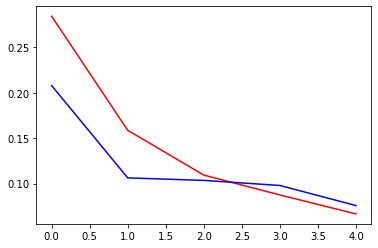

In [0]:

learner = Learner(model_ft,criterion)

optimizer = optim.Adam(model_ft.parameters(), lr = 3e-4)
#optimizer= optim.SGD(model_ft.parameters(),lr=0.0045)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
learner.set_optimizer(optimizer,scheduler)

learner.set_datasets(image_datasets['train'],image_datasets['valid'])

learner.train(5,64,128,batch_cap=32)

#learner.train(10,128,128,batch_cap=32)

#learner.train(10,512,128,batch_cap=32)

Epoch 0 of 14
Training:
  Avg Loss=0.09953156950276022
  Accuracy=0.9666226040978189
Validation:
  Avg Loss=0.13765022344887257
  Accuracy=0.953125

Epoch 1 of 14
Training:
  Avg Loss=0.09909089534036859
  Accuracy=0.9676140118968936
Validation:
  Avg Loss=0.12710127606987953
  Accuracy=0.953125

Epoch 2 of 14
Training:
  Avg Loss=0.09249476957709207
  Accuracy=0.9692663582286847
Validation:
  Avg Loss=0.17149336263537407
  Accuracy=0.94140625

Epoch 3 of 14
Training:
  Avg Loss=0.09525581311387726
  Accuracy=0.9692663582286847
Validation:
  Avg Loss=0.20471008867025375
  Accuracy=0.923828125

Epoch 4 of 14
Training:
  Avg Loss=0.09117767259586905
  Accuracy=0.9704230006609386
Validation:
  Avg Loss=0.14337097480893135
  Accuracy=0.951171875

Epoch 5 of 14
Training:
  Avg Loss=0.09301300139535128
  Accuracy=0.9702577660277594
Validation:
  Avg Loss=0.13352105394005775
  Accuracy=0.953125

Epoch 6 of 14
Training:
  Avg Loss=0.09802860280120916
  Accuracy=0.969596827495043
Validation:
  

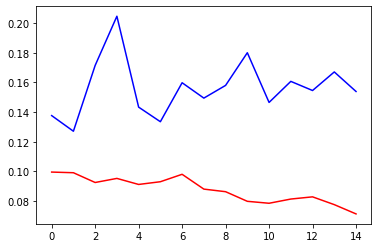

In [0]:
learner.train(15,64,128,batch_cap=32)

In [0]:
learner.change_to_best_model()

In [0]:
#ULearner = UncertaintyLearner(learner.model,criterion)
learner = UncertaintyLearner(model_ft,criterion)

learner.set_optimizer(optimizer,scheduler)

learner.set_datasets(image_datasets['train'],image_datasets['valid'])
torch.cuda.empty_cache()
predictions = learner.predict(image_datasets['valid'],32,2,100)

In [0]:
print(predictions)
label_evaluation=torch.argmax(predictions, dim=2)
print(label_evaluation)
print((label_evaluation==0).sum(dim=0))
#print(labels)

tensor([[[9.9997e-01, 3.3812e-05],
         [9.8262e-01, 1.7384e-02],
         [1.0000e+00, 9.2977e-07],
         ...,
         [7.9007e-01, 2.0993e-01],
         [8.4149e-06, 9.9999e-01],
         [1.8396e-03, 9.9816e-01]],

        [[9.9029e-01, 9.7113e-03],
         [9.3094e-01, 6.9060e-02],
         [9.9999e-01, 1.4749e-05],
         ...,
         [6.9756e-01, 3.0244e-01],
         [4.1762e-05, 9.9996e-01],
         [2.6026e-06, 1.0000e+00]],

        [[9.9992e-01, 8.4664e-05],
         [9.5652e-01, 4.3479e-02],
         [9.9997e-01, 2.8821e-05],
         ...,
         [1.9664e-01, 8.0336e-01],
         [3.3955e-02, 9.6605e-01],
         [5.6168e-06, 9.9999e-01]],

        ...,

        [[1.0000e+00, 1.0510e-06],
         [9.9276e-01, 7.2393e-03],
         [9.9999e-01, 7.5187e-06],
         ...,
         [8.5738e-01, 1.4262e-01],
         [1.0287e-02, 9.8971e-01],
         [6.2619e-03, 9.9374e-01]],

        [[9.9999e-01, 5.3028e-06],
         [9.8802e-01, 1.1985e-02],
         [9.

In [0]:
print(label_evaluation)
print((label_evaluation==0).sum(dim=0))

tensor([[0, 0, 0,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 0, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 0, 1, 1]])
tensor([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 35, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 49, 50, 50, 50, 50, 50, 50

In [0]:
labels = [image_datasets['valid'][i][1] for i in range(len(image_datasets['valid']))]

In [0]:
def confusion_matrix(predictions,true_labels):
  
  TP=FP=TN=FN=PASSED=0
  label_evaluation=torch.argmax(predictions, dim=2)
  print(label_evaluation.size())
  predicted_labels =(label_evaluation==1).sum(dim=0)
  #should take in account the number of evals
  print(predicted_labels.size())
  for i in range(len(predicted_labels)):
    if(predicted_labels[i]<=10):
      if(true_labels[i]==0):
        TP+=1
      else:
        FP+=1
    elif(predicted_labels[i]>=90):
      if(true_labels[i]==1):
        TN+=1
      else:
        FN+=1
    else:
      PASSED+=1
  print("TP: {0} FP: {1}".format(TP,FP))
  print("FN: {0} TN: {1}".format(FN,TN))
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  F1=2*precision*recall/(precision+recall)
  acc=(TP+TN)/(TP+TN+FP+FN)
  print("precision:{0},recall:{1},F1:{2},acc:{3},ask:{4}".format(precision,recall,F1,acc,PASSED))

In [0]:
confusion_matrix(predictions,labels)

torch.Size([100, 512])
torch.Size([512])
TP: 241 FP: 5
FN: 3 TN: 227
precision:0.9796747967479674,recall:0.9877049180327869,F1:0.9836734693877551,acc:0.9831932773109243,ask:36


In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20))
"""Analysis done for two class case
"""
def most_label(predictions,class_label,quantity):
  """Return the indexes of predictions of highes probabilty for that class label
  """
  predictions=torch.index_select(predictions,1,torch.tensor(class_label)) #Select columns of that label
  indexes = torch.argsort(predictions,0,True)
  indexes = torch.flatten(indexes)
  return indexes[:quantity]

def most_correct(predictions,true_labels,quantity):
  """Return the indexes of predictions that are closest to the true label
  """
  true_labels = torch.tensor(true_labels,dtype=torch.float32)
  difference= torch.abs(torch.add(predictions[:,1],torch.neg(true_labels)))
  indexes = torch.argsort(difference,0,False)
  indexes = torch.flatten(indexes)
  return indexes[:quantity]

def most_wrong(predictions,true_labels,quantity):
  """Return the indexes of predictions that are furthest from the true label
  """
  true_labels = torch.tensor(true_labels,dtype=torch.float32)
  difference= torch.abs(torch.add(predictions[:,1],torch.neg(true_labels)))
  indexes = torch.argsort(difference,0,True)
  indexes = torch.flatten(indexes)
  return indexes[:quantity]
def filter_correct(predictions,dataset,correct=True):
  """"Return filtered predictions that are correct or wrong, according to the correct param
  """
  #PROBLEM:RETURNS PREDICTIONS WITHOUT INDEXES
  #To get indexes: indexes = torch.tensor(range(len(dataset)))
  #indexes = indexes[predicted_labels==labels]
  labels = [dataset[i][1] for i in range(len(dataset))]
  labels = torch.tensor(labels)
  predicted_labels=torch.argmax(predictions, dim=1)
  if(correct):
    print(predictions[predicted_labels==labels])
    return predictions[predicted_labels==labels]
  else:
    print(predictions[predicted_labels!=labels])
    return predictions[predicted_labels!=labels]
  
def show_images(indexes,dataset,title=None):  
  """"Use pyplot to show the images of the dataset at indexes
  """
  images = torch.stack([dataset[i][0] for i in indexes.tolist()]) #Stack the images of dataset indexes
  labels = [dataset[i][1] for i in indexes.tolist()]
  plt.ion()
  images = torchvision.utils.make_grid(images)
  inp = images.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated
  print(labels)
def confusion_matrix(predictions,true_labels):
  TP=FP=TN=FN=0
  predicted_labels=torch.argmax(predictions, dim=1)
  for i in range(len(predicted_labels)):
    if(predicted_labels[i]==0):
      if(true_labels[i]==0):
        TP+=1
      else:
        FP+=1
    if(predicted_labels[i]==1):
      if(true_labels[i]==1):
        TN+=1
      else:
        FN+=1
  print("TP: {0} FP: {1}".format(TP,FP))
  print("FN: {0} TN: {1}".format(FN,TN))
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  F1=2*precision*recall/(precision+recall)
  acc=(TP+TN)/(TP+TN+FP+FN)
  print("precision:{0},recall:{1},F1:{2},acc:{3}".format(precision,recall,F1,acc))

#predictions=filter_correct(predictions,image_datasets['valid'],correct=False)
#indexes = most_label(predictions,1,50)
#show_images(indexes,image_datasets['valid'])

<Figure size 2880x1440 with 0 Axes>

In [0]:
confusion_matrix(predictions,labels)

RuntimeError: ignored

In [0]:
print(most_wrong(predictions,labels,47))

In [0]:
print(predictions[most_wrong(predictions,labels,30),1])

In [0]:
print(torch.tensor(labels)[most_wrong(predictions,labels,15)])

In [0]:
print(torch.tensor(labels,dtype=torch.float32)[most_wrong(predictions,labels,47)]-predictions[most_wrong(predictions,labels,47),1])

In [0]:
((torch.tensor(labels,dtype=torch.float32)[most_wrong(predictions,labels,300)]-predictions[most_wrong(predictions,labels,300),1]).abs()>=0.5).sum()

In [0]:
plt.figure(figsize=(60,40))
show_images(most_wrong(predictions,labels,47),image_datasets['valid'])

In [0]:
predictions[most_wrong(predictions,labels,86)]

In [0]:

class ImageFolderPaths(datasets.ImageFolder):
    """Custom dataset that returns the image path
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        return self.imgs[index][0]
       


In [0]:
paths = ImageFolderPaths('MeteorosIC/labeled_data/valid',data_transforms['test'])

In [0]:
images = [paths[i] for i in most_wrong(predictions,labels,47).tolist()] #Stack the images of dataset indexes
print (images)

In [0]:
print(most_label(filtered_predictions,0,36))

In [0]:
plt.figure(figsize=(40,20))
show_images(most_label(filtered_predictions,0,36),image_datasets['valid'])